# Two-Layer FinTech Fraud Detection using Benford’s Law and Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
df=pd.read_csv("Paysim.csv")

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns)
print("\nFraud Distribution:\n", df['isFraud'].value_counts())

Shape: (6362620, 11)

Columns:
 Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

Fraud Distribution:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64


### Keep only relevant columns for now

In [5]:
df_proj = df[['amount', 'isFraud']].copy()
df_proj.head()

,amount,isFraud
0,9839.64,0
1,1864.28,0
2,181.00,1
3,181.00,1
4,11668.14,0


# Basic EDA

Fraud Rate: 0.1291%


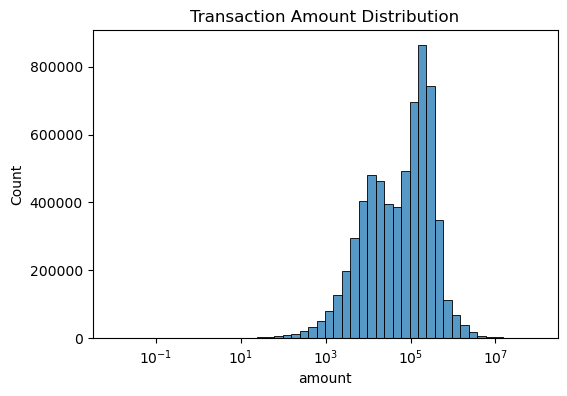

In [6]:
# Fraud percentage
fraud_rate = df_proj['isFraud'].mean() * 100
print(f"Fraud Rate: {fraud_rate:.4f}%")
# Amount distribution
plt.figure(figsize=(6,4))
sns.histplot(df_proj['amount'], bins=50, log_scale=True)
plt.title("Transaction Amount Distribution")
plt.show()

### First Non-Zero Digit Extraction

In [7]:
def first_non_zero_digit(x):
    x = abs(x)
    while x >= 10:
        x //= 10
    return int(x) if x > 0 else np.nan
df_proj['first_digit'] = df_proj['amount'].apply(first_non_zero_digit)
df_proj[['amount', 'first_digit']].head()

,amount,first_digit
0,9839.64,9.0
1,1864.28,1.0
2,181.00,1.0
3,181.00,1.0
4,11668.14,1.0


### Actual Digit Distribution

In [8]:
actual_dist = (
    df_proj['first_digit']
    .value_counts(normalize=True)
    .sort_index()
)
actual_dist

first_digit
0.0    0.000018
1.0    0.335950
2.0    0.204655
3.0    0.125484
4.0    0.082778
5.0    0.062199
6.0    0.052539
7.0    0.048080
8.0    0.045194
9.0    0.043103
Name: proportion, dtype: float64

### Expected Benford Distribution

In [9]:
benford_dist = {
    d: np.log10(1 + 1/d) for d in range(1, 10)
}

benford_dist = pd.Series(benford_dist)
benford_dist


1    0.301030
2    0.176091
3    0.124939
4    0.096910
5    0.079181
6    0.066947
7    0.057992
8    0.051153
9    0.045757
dtype: float64

### Benford Comparison Plot

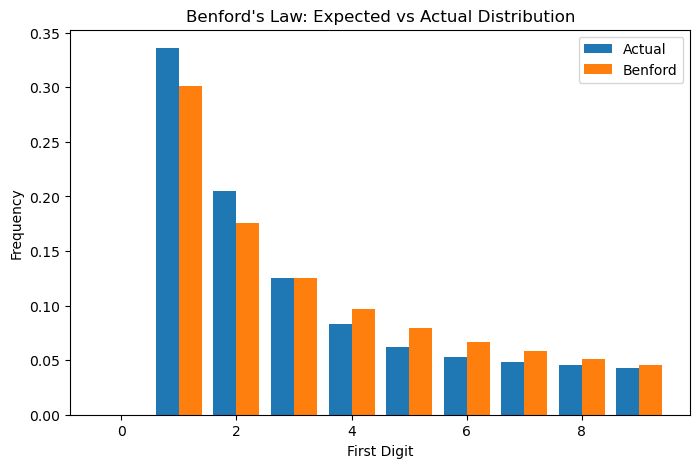

In [10]:
plt.figure(figsize=(8,5))
plt.bar(actual_dist.index - 0.2, actual_dist.values, width=0.4, label='Actual')
plt.bar(benford_dist.index + 0.2, benford_dist.values, width=0.4, label='Benford')
plt.xlabel("First Digit")
plt.ylabel("Frequency")
plt.title("Benford's Law: Expected vs Actual Distribution")
plt.legend()
plt.show()

### Split Fraud vs Normal

In [11]:
df_normal = df_proj[df_proj['isFraud'] == 0]
df_fraud  = df_proj[df_proj['isFraud'] == 1]

print("Normal transactions:", len(df_normal))
print("Fraud transactions:", len(df_fraud))


Normal transactions: 6354407
Fraud transactions: 8213


### Digit Distribution Function

In [12]:
def digit_distribution(df):
    return (
        df['first_digit']
        .value_counts(normalize=True)
        .sort_index()
        .reindex(range(1,10), fill_value=0)
    )

### Fraud vs Normal Distributions

In [13]:
normal_dist = digit_distribution(df_normal)
fraud_dist  = digit_distribution(df_fraud)
normal_dist, fraud_dist

(first_digit
 1    0.335978
 2    0.204694
 3    0.125491
 4    0.082761
 5    0.062187
 6    0.052526
 7    0.048064
 8    0.045186
 9    0.043097
 Name: proportion, dtype: float64,
 first_digit
 1    0.314749
 2    0.174698
 3    0.120288
 4    0.096499
 5    0.071490
 6    0.062462
 7    0.060388
 8    0.051360
 9    0.048066
 Name: proportion, dtype: float64)

# Plot: Fraud vs Normal

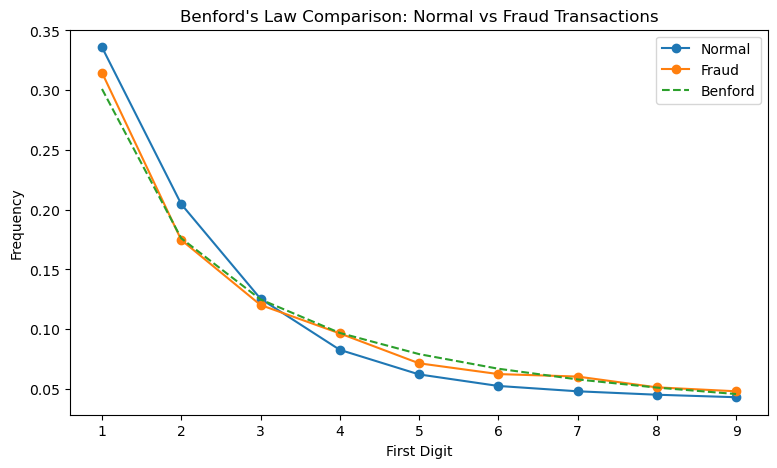

In [14]:
plt.figure(figsize=(9,5))

plt.plot(normal_dist.index, normal_dist.values, marker='o', label='Normal')
plt.plot(fraud_dist.index, fraud_dist.values, marker='o', label='Fraud')
plt.plot(benford_dist.index, benford_dist.values, linestyle='--', label='Benford')

plt.xlabel("First Digit")
plt.ylabel("Frequency")
plt.title("Benford's Law Comparison: Normal vs Fraud Transactions")
plt.legend()
plt.show()


### Deviation Score Function

In [15]:
def benford_deviation(actual, expected):
    return np.sum(np.abs(actual - expected))


### Compute Deviation Scores

In [16]:
normal_dev = benford_deviation(normal_dist, benford_dist)
fraud_dev  = benford_deviation(fraud_dist, benford_dist)

print("Benford Deviation (Normal):", round(normal_dev, 4))
print("Benford Deviation (Fraud):", round(fraud_dev, 4))


Benford Deviation (Normal): 0.1282
Benford Deviation (Fraud): 0.0373


# MACHINE LEARNING MODEL

### Feature Selection

In [17]:
# Features and target
X = df[['amount']]
y = df['isFraud']

print(X.shape, y.shape)


(6362620, 1) (6362620,)


### Train–Test Split

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train fraud rate:", y_train.mean())
print("Test fraud rate:", y_test.mean())


Train fraud rate: 0.001290797995614565
Test fraud rate: 0.001290872837499856


### Train Random Forest

In [19]:
import time
from sklearn.ensemble import RandomForestClassifier

print("Training started...")
start = time.time()

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

end = time.time()
print(f"Training finished in {(end-start)/60:.2f} minutes")


Training started...
Training finished in 15.38 minutes


### Predictions & Probabilities

In [20]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


[[1903844    2478]
 [    755    1709]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.41      0.69      0.51      2464

    accuracy                           1.00   1908786
   macro avg       0.70      0.85      0.76   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC-AUC: 0.8516408680214789


# FULL DATA RF APPLY

In [21]:
df['ml_prob'] = rf.predict_proba(df[['amount']])[:, 1]
df['ml_pred'] = (df['ml_prob'] > 0.5).astype(int)

df['ml_pred'].value_counts()


ml_pred
0    6349968
1      12652
Name: count, dtype: int64

### RF-FLAGGED FRAUD SUBSET

In [22]:
rf_fraud = df[df['ml_pred'] == 1].copy()
len(rf_fraud)


12652

### First non-zero digit

In [23]:
def first_non_zero_digit(x):
    x = abs(x)
    while x >= 10:
        x //= 10
    return int(x) if x > 0 else None

rf_fraud['first_digit'] = rf_fraud['amount'].apply(first_non_zero_digit)


### Digit distribution

In [24]:
rf_digit_dist = (
    rf_fraud['first_digit']
    .value_counts(normalize=True)
    .sort_index()
    .reindex(range(1,10), fill_value=0)
)

rf_digit_dist


first_digit
1    0.475467
2    0.135169
3    0.095125
4    0.072966
5    0.051994
6    0.047879
7    0.045030
8    0.040203
9    0.036167
Name: proportion, dtype: float64

# Benford expected distribution

In [25]:
import numpy as np
import pandas as pd

benford_dist = pd.Series(
    {d: np.log10(1 + 1/d) for d in range(1, 10)}
)


# MIC Drop Graph

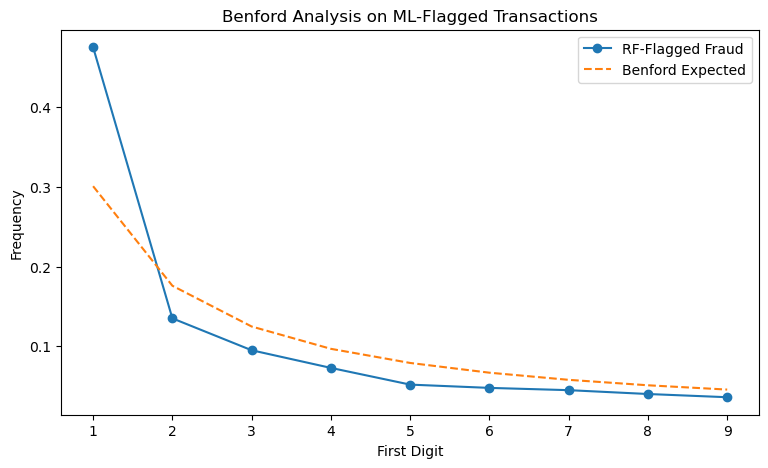

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.plot(rf_digit_dist.index, rf_digit_dist.values, marker='o', label='RF-Flagged Fraud')
plt.plot(benford_dist.index, benford_dist.values, linestyle='--', label='Benford Expected')

plt.xlabel("First Digit")
plt.ylabel("Frequency")
plt.title("Benford Analysis on ML-Flagged Transactions")
plt.legend()
plt.show()


# Benford deviation score

In [27]:
def benford_deviation(actual, expected):
    return np.sum(np.abs(actual - expected))

rf_benford_dev = benford_deviation(rf_digit_dist, benford_dist)
rf_benford_dev


np.float64(0.3488738484947663)

### While Benford’s Law alone did not distinguish fraud in the full dataset, applying it to machine-learning-flagged transactions revealed strong numerical irregularities. This demonstrates that Benford’s Law is most effective as a secondary validation tool, enhancing confidence in fraud detection when combined with machine learning models.

### The model was trained on a stratified train–test split and then deployed on the full dataset for large-scale fraud screening, followed by statistical validation using Benford’s Law